In [ ]:
import tkinter as tk
from tkinter import ttk, messagebox
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.animation import FuncAnimation
import time

: 

In [14]:

G = 9.81
DT = 0.05

def F_tc(tc, D, h, v, phi_deg, T, u_max):
    phi_rad = np.deg2rad(phi_deg)
    den = tc - T
    if abs(den) < 1e-9: return 1e9
    
    ux = (D - (v * np.cos(phi_rad) * tc)) / den
    term2 = v * np.sin(phi_rad) * tc
    term3 = 0.5 * G * (tc**2 - den**2)
    uy = (h + term2 - term3) / den
    return (ux**2 + uy**2) - u_max**2


def metodo_secante(D, h, v, phi_deg, T, u_max):
    t_prev, t_curr = T + 0.5, T + 1.0
    
    iteraciones = 0

    for i in range(50):
        iteraciones += 1

        # Calculamos el valor de la función para t_prev y t_curr
        f_prev = F_tc(t_prev, D, h, v, phi_deg, T, u_max)
        f_curr = F_tc(t_curr, D, h, v, phi_deg, T, u_max)
        
        # Calculamos la diferencia entre las funciones f_curr y f_prev
        denom = f_curr - f_prev
        
        # Si la diferencia entre las funciones es muy pequeña, evitamos la división por cero
        if abs(denom) < 1e-10:  # Condición de parada para evitar la división por cero
            break
        
        # Calculamos el siguiente valor de t (t_next) utilizando la fórmula de la secante
        t_next = t_curr - f_curr * ((t_curr - t_prev) / denom)
        
        # Condición de parada: si la diferencia entre t_next y t_curr es suficientemente pequeña
        if abs(t_next - t_curr) < 1e-5:
            return t_next, iteraciones  # Devolvemos el valor de t_next y el número de iteraciones

        # Actualizamos t_prev y t_curr para la siguiente iteración
        t_prev, t_curr = t_curr, t_next

    # Si no hemos alcanzado la convergencia rápidamente, devolvemos el último valor de t_curr
    return t_curr, iteraciones  # Devolvemos el valor de t_curr y el número de iteraciones

def metodo_biseccion_dinamico(D, h, v, phi_deg, T, u_max, tol=1e-5, max_iter=100):
    """
    Método de Bisección dinámico con búsqueda de intervalo inicial.
    Busca de forma progresiva un intervalo [a, b] que contenga la raíz.
    """
    iteraciones = 0
    
    # 1. BÚSQUEDA DINÁMICA DEL INTERVALO INICIAL [a, b]
    
    # Inicialización: comenzamos con un punto cerca de T (el tiempo mínimo de T2)
    t_start = T + 0.01  # Pequeño offset para evitar la singularidad
    delta = 0.1         # Tamaño inicial del paso
    
    a = t_start
    f_a = F_tc(a, D, h, v, phi_deg, T, u_max)
    
    # Expandir el intervalo progresivamente
    while True:
        b = a + delta
        f_b = F_tc(b, D, h, v, phi_deg, T, u_max)
        
        # Si encontramos un cambio de signo, el intervalo es válido
        if f_a * f_b < 0:
            break
        
        # Si no hay cambio de signo, movemos 'a' a 'b' y aumentamos el paso 'delta'
        a = b
        f_a = f_b
        delta *= 2  # Aumentar el paso (expansión exponencial) para buscar más rápido
        
        # Condición de seguridad para la búsqueda inicial (ej: tiempo máximo razonable)
        if a > T + 20.0: 
            # Si el tiempo supera un límite razonable, asumimos que no hay solución en el rango
            return None, 0, "No se encontró intervalo inicial válido."

    # 2. ALGORITMO DE BISECCIÓN CLÁSICO
    
    # Si llegamos aquí, [a, b] es un intervalo válido que contiene la raíz.
    while iteraciones < max_iter:
        iteraciones += 1
        c = (a + b) / 2
        f_c = F_tc(c, D, h, v, phi_deg, T, u_max)
        
        # Condición de convergencia: si el intervalo es suficientemente pequeño
        if abs(b - a) < tol: 
            return c, iteraciones, "Convergencia alcanzada por tolerancia."

        # Reducir el intervalo
        if f_a * f_c < 0:
            # La raíz está en [a, c]
            b = c
        else:
            # La raíz está en [c, b]
            a = c
            f_a = f_c # Actualizar f(a) para la siguiente iteración (esto ahorra un cálculo)
            
    # Si se supera el número máximo de iteraciones
    return c, iteraciones, "Máximo de iteraciones alcanzado."

def generar_trayectorias(tc, D, h, v, phi_deg, T, C_arrastre, sigma_ruido):
    # 1. Recalcular condiciones P2 para el choque TEÓRICO
    phi_rad = np.deg2rad(phi_deg)
    den = tc - T
    
    # Velocidades iniciales
    vx1_inic = - (v * np.cos(phi_rad)) 
    vy1_inic = v * np.sin(phi_rad)
    
    ux = (D - (v * np.cos(phi_rad) * tc)) / den
    term2 = v * np.sin(phi_rad) * tc
    term3 = 0.5 * G * (tc**2 - den**2)
    uy = (h + term2 - term3) / den
    
    # --- CÁLCULO DEL PUNTO EXACTO DE COLISIÓN (EL IMÁN) ---
    # Calculamos dónde deberían estar matemáticamente en el tiempo exacto 'tc'
    # (Usamos las fórmulas sin ruido ni arrastre para saber el punto perfecto)
    x_impacto_exacto = D + vx1_inic * tc
    y_impacto_exacto = h + vy1_inic * tc - 0.5 * G * tc**2
    
    # 2. Simulación RK4
    t = 0.0
    estado_p1 = np.array([D, h, vx1_inic, vy1_inic])
    estado_p2 = np.array([0.0, 0.0, ux, uy]) 
    
    hx1, hy1, hx2, hy2 = [], [], [], []
    
    # Corremos la simulación hasta justo antes del choque
    while t < tc:
        hx1.append(estado_p1[0]); hy1.append(estado_p1[1])
        hx2.append(estado_p2[0]); hy2.append(estado_p2[1])
        
        # RK4 Simplificado
        # P1
        v_mag1 = np.sqrt(estado_p1[2]**2 + estado_p1[3]**2)
        ax1 = -C_arrastre * v_mag1 * estado_p1[2]
        ay1 = -G - (C_arrastre * v_mag1 * estado_p1[3])
        
        estado_p1[0] += estado_p1[2] * DT
        estado_p1[1] += estado_p1[3] * DT
        estado_p1[2] += ax1 * DT + np.random.normal(0, sigma_ruido)
        estado_p1[3] += ay1 * DT + np.random.normal(0, sigma_ruido)
        
        # P2 (Solo si t > T)
        if t >= T:
            v_mag2 = np.sqrt(estado_p2[2]**2 + estado_p2[3]**2)
            ax2 = -C_arrastre * v_mag2 * estado_p2[2]
            ay2 = -G - (C_arrastre * v_mag2 * estado_p2[3])
            
            estado_p2[0] += estado_p2[2] * DT
            estado_p2[1] += estado_p2[3] * DT
            estado_p2[2] += ax2 * DT + np.random.normal(0, sigma_ruido)
            estado_p2[3] += ay2 * DT + np.random.normal(0, sigma_ruido)
        
        t += DT
        
        # Si alguno cae al suelo antes de tiempo, paramos
        if estado_p1[1] < 0 and estado_p2[1] < 0: break

    # --- EL TRUCO FINAL ---
    # Forzamos que el último punto registrado sea EXACTAMENTE el punto de choque.
    # Esto asegura que visualmente siempre se toquen al final.
    if y_impacto_exacto >= 0: # Solo si el choque es sobre el suelo
        hx1.append(x_impacto_exacto)
        hy1.append(y_impacto_exacto)
        hx2.append(x_impacto_exacto)
        hy2.append(y_impacto_exacto)

    return hx1, hy1, hx2, hy2, np.sqrt(ux**2+uy**2), np.degrees(np.arctan2(uy, ux))

In [15]:
class AplicacionPro:
    def __init__(self, root):
        self.root = root
        self.root.title("Simulación Avanzada de Colisión de Proyectiles")
        self.root.geometry("1100x650")
        self.root.configure(bg="#f0f0f0")

        self.var_D = tk.DoubleVar(value=100.0)
        self.var_h = tk.DoubleVar(value=20.0)
        self.var_v = tk.DoubleVar(value=30.0)
        self.var_phi = tk.DoubleVar(value=45.0)
        self.var_T = tk.DoubleVar(value=1.0)
        self.var_umax = tk.DoubleVar(value=100.0)
        self.var_viento = tk.BooleanVar(value=False)
        self.metodo_sel = tk.StringVar(value="Secante")
        
        self.ani = None
        self.hx1, self.hy1, self.hx2, self.hy2 = [], [], [], []
        self.crear_layout()

    def crear_layout(self):
        panel_izq = tk.Frame(self.root, width=300, bg="#e0e0e0", padx=10, pady=10)
        panel_izq.pack(side=tk.LEFT, fill=tk.Y)
        
        estilo = {'bg': "#e0e0e0", 'font': ('Arial', 10)}
        
        # Inputs
        fp = tk.LabelFrame(panel_izq, text="Parámetros Iniciales P1", font=('Arial', 10, 'bold'), bg="#e0e0e0")
        fp.pack(fill=tk.X, pady=5, ipady=5)
        campos = [("Distancia D:", self.var_D), ("Altura h:", self.var_h), 
                  ("Velocidad v:", self.var_v), ("Ángulo φ:", self.var_phi),
                  ("Retraso T:", self.var_T), ("Potencia P2:", self.var_umax)]
        for i, (t, v) in enumerate(campos):
            tk.Label(fp, text=t, **estilo).grid(row=i, column=0, sticky='w', padx=5)
            tk.Entry(fp, textvariable=v, width=10).grid(row=i, column=1, padx=5)

        # Opciones
        fo = tk.LabelFrame(panel_izq, text="Opciones", font=('Arial', 10, 'bold'), bg="#e0e0e0")
        fo.pack(fill=tk.X, pady=10)
        tk.Checkbutton(fo, text="Viento (Ruido)", variable=self.var_viento, bg="#e0e0e0").pack(anchor='w', padx=10)
        tk.Radiobutton(fo, text="Método Secante", variable=self.metodo_sel, value="Secante", bg="#e0e0e0").pack(anchor='w', padx=10)
        tk.Radiobutton(fo, text="Método Bisección", variable=self.metodo_sel, value="Bisección", bg="#e0e0e0").pack(anchor='w', padx=10)
        
        tk.Button(fo, text="SIMULAR", bg="#4CAF50", fg="white", font=('Arial', 12, 'bold'), command=self.calcular).pack(fill=tk.X, padx=10, pady=5)
        tk.Button(fo, text="COMPARAR MÉTODOS", bg="#2196F3", fg="white", font=('Arial', 10, 'bold'), command=self.comparar_metodos).pack(fill=tk.X, padx=10, pady=5)

        # Resultados
        fr = tk.LabelFrame(panel_izq, text="Resultados", font=('Arial', 10, 'bold'), bg="#e0e0e0")
        fr.pack(fill=tk.X, pady=10)
        self.lbl_u = tk.Label(fr, text="u calc: ---", fg="green", bg="#e0e0e0", font=('Courier', 10, 'bold')); self.lbl_u.pack()
        self.lbl_th = tk.Label(fr, text="θ calc: ---", fg="green", bg="#e0e0e0", font=('Courier', 10, 'bold')); self.lbl_th.pack()
        self.lbl_tc = tk.Label(fr, text="T col: ---", fg="green", bg="#e0e0e0", font=('Courier', 10, 'bold')); self.lbl_tc.pack()
        self.lbl_iter = tk.Label(fr, text="Iteraciones: ---", fg="blue", bg="#e0e0e0", font=('Courier', 9)); self.lbl_iter.pack()
        
        # Gráfica
        panel_der = tk.Frame(self.root, bg="white")
        panel_der.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=10, pady=10)
        self.fig, self.ax = plt.subplots(dpi=100)
        self.canvas = FigureCanvasTkAgg(self.fig, master=panel_der)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    def validar_parametros(self):
        """Validación de parámetros de entrada"""
        if self.var_D.get() <= 0:
            raise ValueError("D debe ser > 0")
        if self.var_v.get() <= 0:
            raise ValueError("v debe ser > 0")
        if not (0 <= self.var_phi.get() <= 90):
            raise ValueError("φ debe estar entre 0° y 90°")
        if self.var_T.get() < 0:
            raise ValueError("T debe ser ≥ 0")
        if self.var_umax.get() <= 0:
            raise ValueError("Potencia P2 debe ser > 0")

    def calcular(self):
        try:
            self.validar_parametros()
            
            D, h, v = self.var_D.get(), self.var_h.get(), self.var_v.get()
            phi, T, umax = self.var_phi.get(), self.var_T.get(), self.var_umax.get()
            
            # Selección de método
            if self.metodo_sel.get() == "Secante":
                tc, iteraciones = metodo_secante(D, h, v, phi, T, umax)
            else:
                # 🔄 CAMBIO CLAVE AQUÍ: Usamos el método dinámico y capturamos el status
                tc, iteraciones, status = metodo_biseccion_dinamico(D, h, v, phi, T, umax)
                if tc is None:
                    raise ValueError(f"Bisección falló en la búsqueda de intervalo: {status}")

            if tc > 50 or tc < T: raise ValueError("No converge o tc < T")
            
            C = 0.001 if self.var_viento.get() else 0.0
            sigma = 0.05 if self.var_viento.get() else 0.0
            self.hx1, self.hy1, self.hx2, self.hy2, u_res, th_res = generar_trayectorias(tc, D, h, v, phi, T, C, sigma)
            
            self.lbl_u.config(text=f"u calc: {u_res:.2f} m/s")
            self.lbl_th.config(text=f"θ calc: {th_res:.2f}°")
            self.lbl_tc.config(text=f"T col: {tc:.2f} s")
            self.lbl_iter.config(text=f"Iteraciones: {iteraciones}")
            
            self.animar()
            
        except Exception as e:
            messagebox.showerror("Error", f"Error en cálculo:\n{str(e)}")

    def comparar_metodos(self):
        try:
            self.validar_parametros()
            
            D, h, v, phi, T, umax = (self.var_D.get(), self.var_h.get(), 
                                      self.var_v.get(), self.var_phi.get(), 
                                      self.var_T.get(), self.var_umax.get())
            
            # Método Secante
            t0 = time.perf_counter()
            tc_sec, iter_sec = metodo_secante(D, h, v, phi, T, umax)
            tiempo_sec = time.perf_counter() - t0
            
            # Método Bisección
            t0 = time.perf_counter()
            # 🔄 CAMBIO CLAVE AQUÍ: Llamamos al método dinámico y capturamos el status
            tc_bis, iter_bis, status = metodo_biseccion_dinamico(D, h, v, phi, T, umax)
            tiempo_bis = time.perf_counter() - t0
            
            # Manejar el posible fallo de convergencia (aunque es poco probable para Bisección)
            if tc_bis is None:
                messagebox.showwarning("Advertencia", f"Bisección no pudo encontrar el intervalo de la raíz. Resultados Secante válidos.")
                return 

            # Mensaje de comparación
            msg = f"""╔════════════════════════════════════╗
║  COMPARACIÓN DE MÉTODOS NUMÉRICOS   ║
╚════════════════════════════════════╝
     MÉTODO SECANTE:
 • Tiempo colisión: {tc_sec:.6f} s
 • Iteraciones: {iter_sec}
 • Tiempo cómputo: {tiempo_sec*1000:.4f} ms
 • Convergencia: Superlineal (~φ¹·⁶¹⁸)

    MÉTODO BISECCIÓN (Dinámico):
 • Tiempo colisión: {tc_bis:.6f} s
 • Iteraciones: {iter_bis}
 • Tiempo cómputo: {tiempo_bis*1000:.4f} ms
 • Convergencia: Lineal

    ANÁLISIS:
 • Diferencia tc: {abs(tc_sec - tc_bis):.8f} s
 • Ratio iteraciones: {iter_bis/iter_sec:.2f}x
 • Speedup: {tiempo_bis/tiempo_sec:.2f}x más rápido (Secante)

    CONCLUSIÓN:
El método Secante es más eficiente con menos
iteraciones y convergencia más rápida,
pero la Bisección Dinámica es más robusta."""
            
            messagebox.showinfo("Comparación de Métodos", msg)
            
        except Exception as e:
            messagebox.showerror("Error", f"Error en comparación:\n{str(e)}")

    def animar(self):
        if len(self.hx1) == 0 or len(self.hx2) == 0:
            messagebox.showwarning("Advertencia", "No hay datos para animar")
            return
            
        self.ax.clear()
        self.ax.grid(True, linestyle='--', alpha=0.6)
        

        # 1. Encontrar valores MÍNIMOS y MÁXIMOS en X (incluye negativos)
        min_x = min(min(self.hx1), min(self.hx2), 0, self.var_D.get())
        max_x = max(max(self.hx1), max(self.hx2), 0, self.var_D.get())
        
        # 2. Encontrar valores MÍNIMOS y MÁXIMOS en Y (incluye negativos)
        min_y = min(min(self.hy1), min(self.hy2), 0, self.var_h.get())
        max_y = max(max(self.hy1), max(self.hy2), 0, self.var_h.get())
        
        # 3. Calcular márgenes del 15% para que se vea bien
        margen_x = (max_x - min_x) * 0.15
        margen_y = (max_y - min_y) * 0.15
        
        # 4. Aplicar límites con márgenes
        self.ax.set_xlim(min_x - margen_x, max_x + margen_x)
        self.ax.set_ylim(min_y - margen_y, max_y + margen_y)
        
        self.ax.axhline(0, color='black', linewidth=2)
        self.ax.set_xlabel("Distancia (m)", fontsize=11, fontweight='bold')
        self.ax.set_ylabel("Altura (m)", fontsize=11, fontweight='bold')
        self.ax.set_title("Trayectorias de Colisión", fontsize=13, fontweight='bold')
        
        # Creación de elementos gráficos
        self.linea1, = self.ax.plot([], [], 'r--', linewidth=2, label='Proyectil 1')
        self.punto1, = self.ax.plot([], [], 'ro', markersize=8)
        self.linea2, = self.ax.plot([], [], 'b-', linewidth=2, label='Proyectil 2')
        self.punto2, = self.ax.plot([], [], 'bo', markersize=8)
        self.colision, = self.ax.plot([], [], 'k*', markersize=20, visible=False, label='💥 Colisión')
        self.ax.legend(loc='upper right', fontsize=10)
        
        def update(frame):
            self.linea1.set_data(self.hx1[:frame], self.hy1[:frame])
            self.punto1.set_data([self.hx1[frame]], [self.hy1[frame]])
            
            idx2 = min(frame, len(self.hx2)-1)
            if frame < len(self.hx2):
                self.linea2.set_data(self.hx2[:idx2], self.hy2[:idx2])
                self.punto2.set_data([self.hx2[idx2]], [self.hy2[idx2]])
            
            if frame == len(self.hx1) - 1:
                self.colision.set_data([self.hx2[-1]], [self.hy2[-1]])
                self.colision.set_visible(True)
                
            return self.linea1, self.punto1, self.linea2, self.punto2, self.colision

        # Protección contra errores de animación
        if self.ani is not None:
            try:
                self.ani.event_source.stop()
            except AttributeError:
                pass 
        
        self.ani = FuncAnimation(self.fig, update, frames=range(0, len(self.hx1), 2), 
                                 interval=20, blit=False, repeat=False)
        self.canvas.draw()

C:\Users\User\AppData\Local\Temp\ipykernel_7728\2262109790.py:224: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) DejaVu Sans.
  self.canvas.draw()


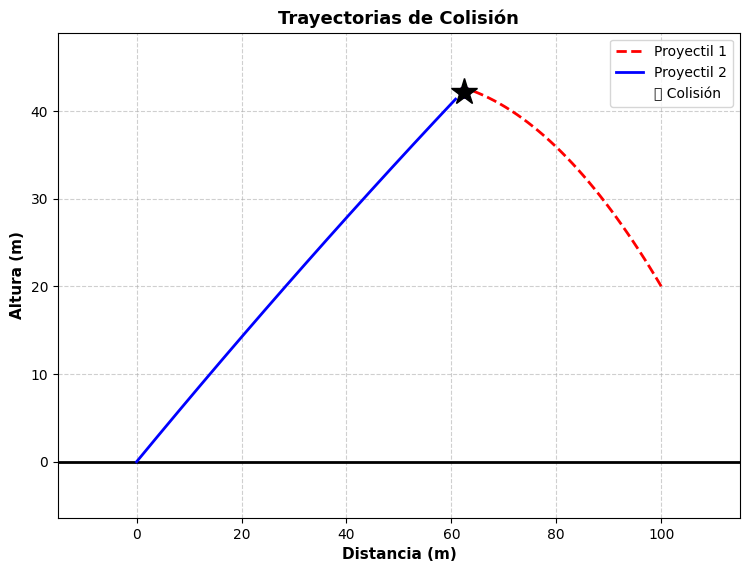

In [16]:
if __name__ == "__main__":
    root = tk.Tk()
    app = AplicacionPro(root)
    root.mainloop()